(参考サイト)
https://www.kaggle.com/code/dsrhul/facial-expression-recognition/notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray

import tensorflow as tf
from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./fer2013.csv
./fer2013_CNN.h5
./fer2013_CNN.ipynb
./fer2013_CNN_loadmodel.py
./.ipynb_checkpoints\fer2013_CNN-checkpoint.ipynb


In [2]:
df = pd.read_csv("fer2013.csv")
output_label = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("Unique labels:",len(np.unique(np.array(df['emotion']))))
print("Pixel type:",type(df['pixels'][2]))
df.tail(5)

Unique labels: 7
Pixel type: <class 'str'>


,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


<AxesSubplot:xlabel='emotion', ylabel='count'>

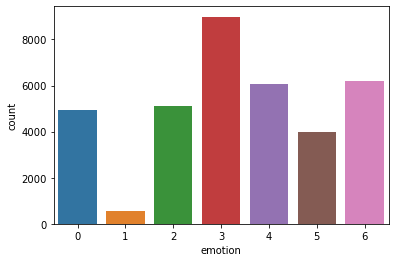

In [3]:
#number of samples per label
sns.countplot(x=df['emotion'], data=df)

In [4]:
#Convert the df['pixels'] str type to array and reshape
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

X= df['pixels'].apply(lambda x: string2array(x))
X = np.array(X)
X = np.stack(X, axis = 0)
X = X/255.0
y = np.array(df['emotion'])

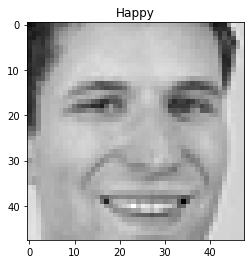

In [5]:
#sample image
img_no = 1246 #image number range(0,35k)
img = X[img_no].reshape(48,48)
plt.figure()
plt.title(output_label[y[img_no]])
plt.imshow(img, cmap = 'gray')

In [6]:
X.shape

(35887, 48, 48, 1)

In [7]:
y.shape

(35887,)

In [8]:
y[0]

0

In [9]:
y[1]

0

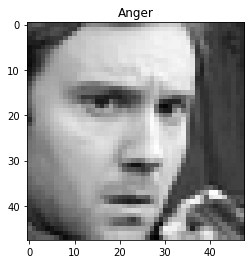

In [10]:
img = X[0].reshape(48,48)
plt.figure()
plt.title(output_label[y[0]])
plt.imshow(img, cmap = 'gray')

In [10]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
print(X.shape,y.shape)

(35887, 48, 48, 1) (35887, 7)


In [11]:
y[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, shuffle = True)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(26915, 48, 48, 1) (26915, 7)
(8972, 48, 48, 1) (8972, 7)


In [14]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization


#defining layers
num_classes = 7
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (4, 4), activation='relu', padding='same', inputs_shape=input_shape))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (4, 4),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))
    
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    validation_split = 0.25,
    fill_mode="nearest")

In [16]:
model.fit(aug.flow(x_train, y_train, batch_size=64),
            epochs=3, 
            verbose=1, 
            shuffle=True,
            )

Epoch 1/3
421/421 [==============================] - 393s 933ms/step - loss: 1.8268 - accuracy: 0.2639
Epoch 2/3
274/421 [==================>...........] - ETA: 2:22 - loss: 1.6674 - accuracy: 0.3429

In [18]:
model.save("fer2013_CNN-v2.h5")
model.save_weights("fer2013_CNN-v2_W.h5")

In [21]:
predictions = model.predict(x_test)

In [22]:
predictions.shape

(8972, 7)

In [27]:
prediction = predictions[1]
print(prediction)

[0.09267104 0.01888936 0.20289534 0.4996118  0.05791998 0.06356227
 0.06445014]


In [28]:
prediction = predictions[1].argmax()
print(prediction)
print(output_label[prediction])

3
Happy


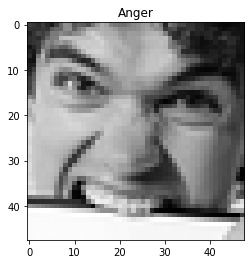

In [29]:
img = x_test[1].reshape(48,48)
plt.figure()
plt.title(output_label[y_test[1].argmax()])
plt.imshow(img, cmap = 'gray')